### Урок3. Связь бизнес-показателей и DS-метрик

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

import warnings
warnings.filterwarnings('ignore')

In [27]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [28]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [29]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [30]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [31]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867397811595499+-0.008587216885603979


In [32]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386943, F-Score=0.730, Precision=0.647, Recall=0.837


In [33]:
def ROC_curve_plt (y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

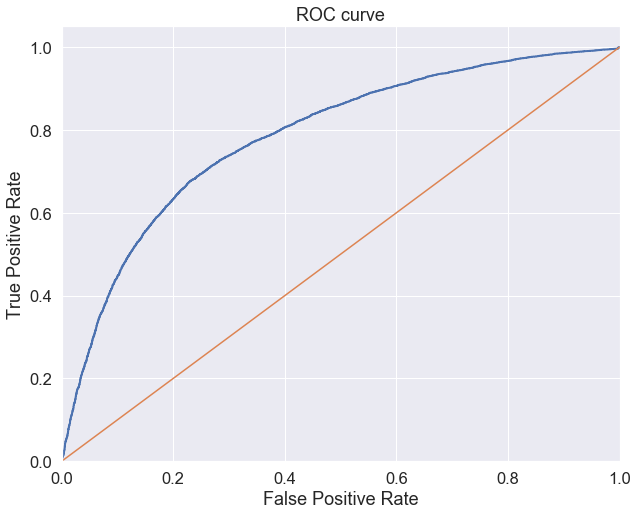

In [34]:
ROC_curve_plt(y_test, y_score)

In [35]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))
roc_auc_score_log = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])

roc auc score: 0.7840286921220101
log loss score: 0.5779642553522364


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4862 3958]
 [1412 7268]]


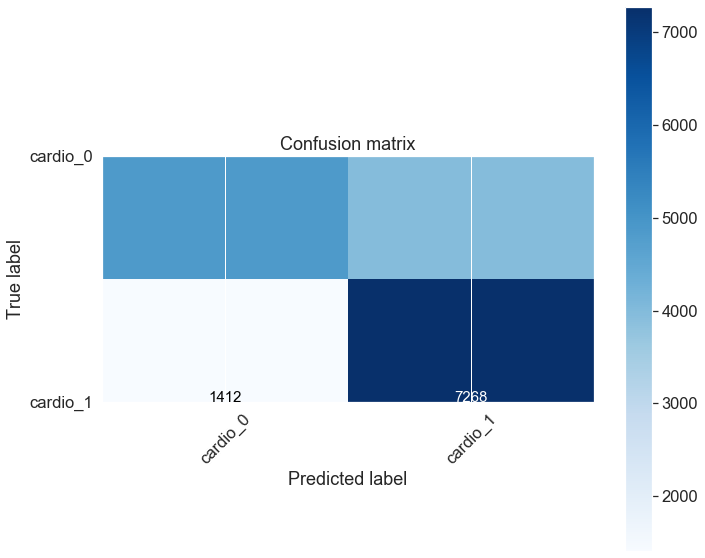

In [37]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Классификатор RandomForestClassifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
RFС = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(max_depth = 8, 
                                          n_estimators = 100, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(RFС, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
RFС.fit(X_train, y_train)
y_score = RFС.predict_proba(X_test)[:, 1]

CV score is 0.8001087294844935+-0.006780708249760675


In [39]:
b=1
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test.values, y_score)
fscore_1 = (1+b**2)*(precision_1 * recall_1) / (b**2*precision_1 + recall_1)
# locate the index of the largest f score
ix = np.argmax(fscore_1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_1[ix], 
                                                                        fscore_1[ix],
                                                                        precision_1[ix],
                                                                        recall_1[ix]))

Best Threshold=0.399504, F-Score=0.739, Precision=0.694, Recall=0.791


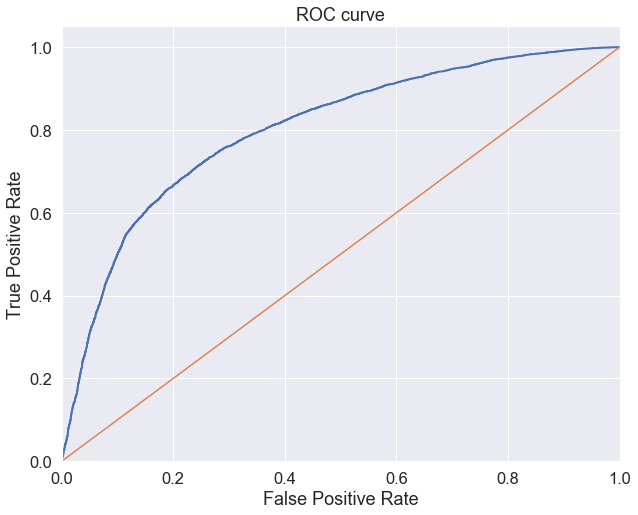

In [40]:
ROC_curve_plt(y_test, y_score)

In [41]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=RFС.predict_proba(X_test)[:,1])))
print("log loss score score: {}".format(log_loss(y_true=y_test, y_pred=RFС.predict_proba(X_test)[:,1])))
roc_auc_score_1 = roc_auc_score(y_true=y_test, y_score=RFС.predict_proba(X_test)[:,1])

roc auc score: 0.8004593208251042
log loss score score: 0.5450055767802114


Confusion matrix, without normalization
[[5793 3027]
 [1818 6862]]


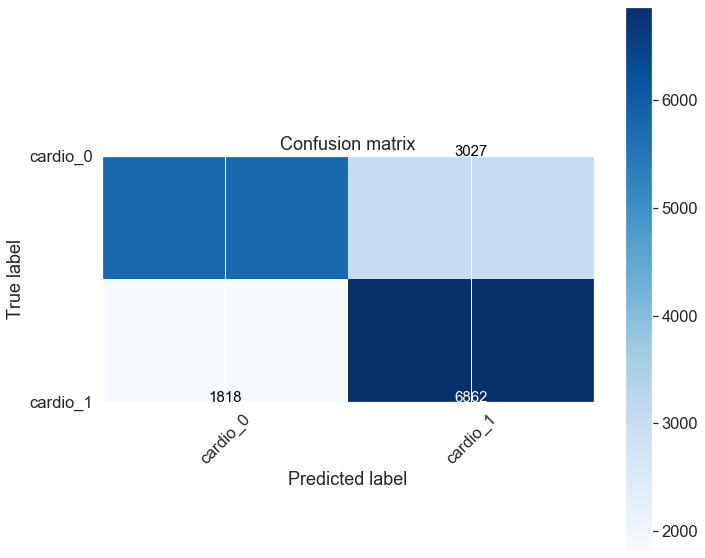

In [42]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds_1[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Классификатор GradientBoostingClassifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
GBС = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(GBС, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
GBС.fit(X_train, y_train)
y_score = GBС.predict_proba(X_test)[:, 1]

CV score is 0.8024721950300286+-0.007119077207003447


In [44]:
b=1
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test.values, y_score)
fscore_2 = (1+b**2)*(precision_2 * recall_2) / (b**2*precision_2 + recall_2)
# locate the index of the largest f score
ix = np.argmax(fscore_2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_2[ix], 
                                                                        fscore_2[ix],
                                                                        precision_2[ix],
                                                                        recall_2[ix]))

Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788


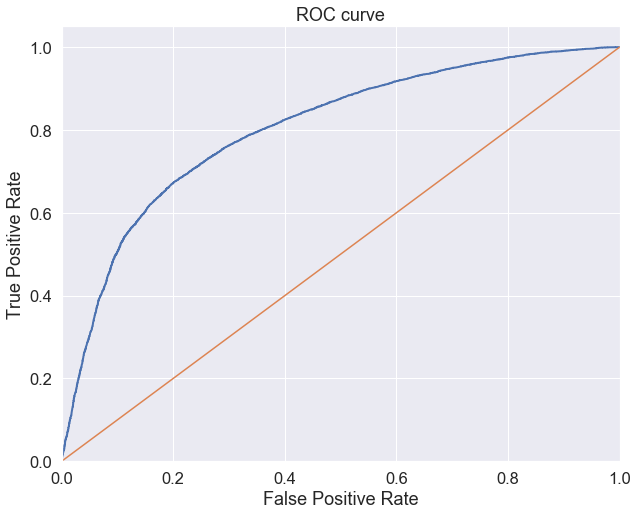

In [45]:
ROC_curve_plt(y_test, y_score)

In [46]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=GBС.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=GBС.predict_proba(X_test)[:,1])))
roc_auc_score_2 = roc_auc_score(y_true=y_test, y_score=GBС.predict_proba(X_test)[:,1])

roc auc score: 0.8026153641179974
log loss score: 0.5397460438742135


Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


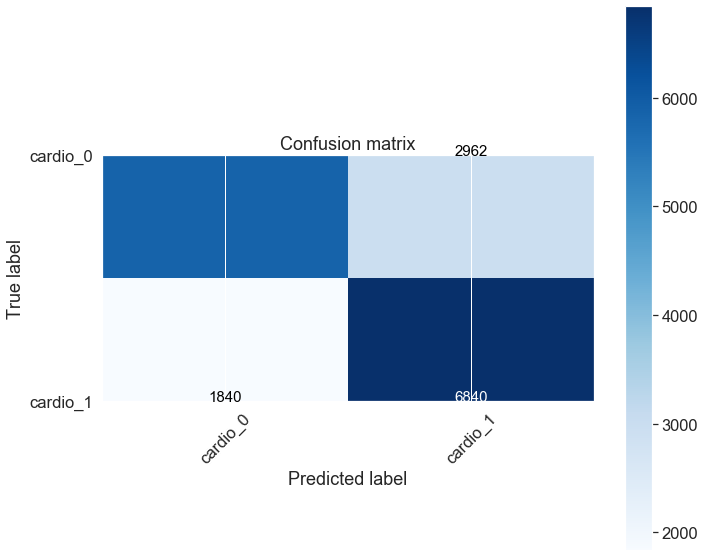

In [47]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds_2[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [48]:
LR_metric = [precision[ix], recall[ix], fscore[ix], roc_auc_score_log]
RFC_metric = [precision_1[ix], recall_1[ix],fscore_1[ix], roc_auc_score_1]
GBC_metric = [precision_2[ix], recall_2[ix],fscore_2[ix], roc_auc_score_2]

In [49]:
metrics = pd.DataFrame({'LogisticRegression': LR_metric,
                        'RandomForestClassifier': RFC_metric,
                        'GradientBoostingClassifier': GBC_metric}).T
metrics.columns=['precision', 'recall','f1_score','Roc_auc_score']

In [50]:
metrics

,precision,recall,f1_score,Roc_auc_score
LogisticRegression,0.615910,0.883065,0.725680,0.784029
RandomForestClassifier,0.634411,0.867857,0.732996,0.800459
GradientBoostingClassifier,0.697848,0.788134,0.740248,0.802615


Градиентный бустинг показал лучший результат по метрикам precision, f1_score, Roc_auc_score  и наименьший  recall. Классификаторы Random Forest и LogisticRegression показали лучшие значения recall.